<a href="https://colab.research.google.com/github/ShrutiGupta37/RSNA-/blob/main/Shruti_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#RUN THIS CELL✅.....



import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm


In [ ]:
#RUN THIS CELL✅.....
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#RUN THIS CELL✅.....
INPUT_DIR = "/content/drive/MyDrive/input"

SEGMENTATION_DIR = "/content/drive/MyDrive/input/segmentation"
SEGMENTATION_TEST_DIR = "/content/drive/MyDrive/input/segmentation /test"
SEGMENTATION_TRAIN_DIR = "/content/drive/MyDrive/input/segmentation /train"
SEGMENTATION_AUG_DIR = "/content/drive/MyDrive/input/segmentation /train/augmentation"
SEGMENTATION_IMAGE_DIR = "/content/drive/MyDrive/input/segmentation /train/image"
SEGMENTATION_MASK_DIR = "/content/drive/MyDrive/input/segmentation /train/mask"
SEGMENTATION_DILATE_DIR = "/content/drive/MyDrive/input/segmentation /train/dilate"

SHENZHEN_IMAGE_DIR = "/content/drive/MyDrive/RSNA Pneumonia dataset/ShenzhenSet/CXR_png"
SHENZHEN_MASK_DIR = "/content/drive/MyDrive/RSNA Pneumonia dataset/ShenzhenSet/mask"

MONTGOMERY_IMAGE_DIR = "/content/drive/MyDrive/RSNA Pneumonia dataset/MontgomerySet/CXR_png"
MONTGOMERY_LEFT_MASK_DIR = "/content/drive/MyDrive/RSNA Pneumonia dataset/MontgomerySet/ManualMask/leftMask"
MONTGOMERY_RIGHT_MASK_DIR = "/content/drive/MyDrive/RSNA Pneumonia dataset/MontgomerySet/ManualMask/rightMask"


DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=2

#Prod
EPOCHS=56

#Desv
#EPOCHS=16


In [ ]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
montgomery_test = montgomery_left_mask_dir[0:50]
montgomery_train= montgomery_left_mask_dir[50:]

for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))

    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)


100%|██████████| 137/137 [03:13<00:00,  1.41s/it]


In [ ]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)

    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

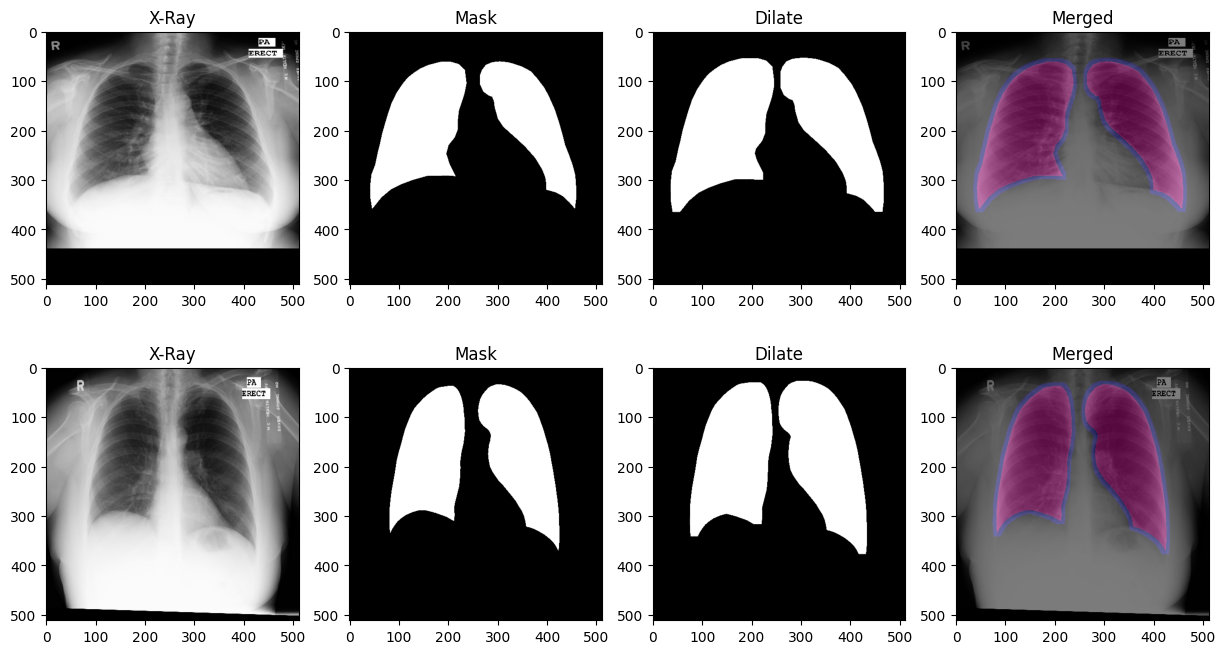

In [ ]:
import matplotlib.pyplot as plt
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)


In [ ]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
shenzhen_test = shenzhen_mask_dir[0:50]
shenzhen_train= shenzhen_mask_dir[50:]

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 566/566 [08:51<00:00,  1.06it/s]


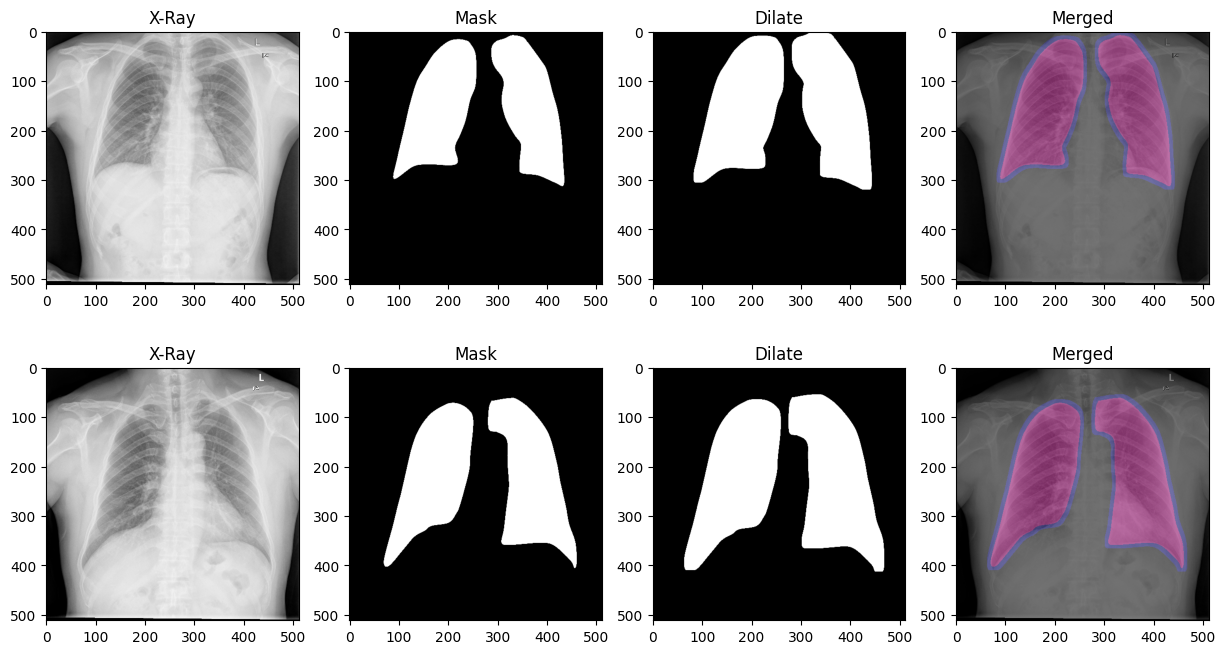

In [ ]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
#RUN THIS CELL✅.....

train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))


(603, 300, 603, 603)

In [ ]:
#RUN THIS CELL✅.....

def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)


In [ ]:
#RUN THIS CELL✅.....

from tensorflow.keras.backend import flatten, sum


def dice_coef(y_true, y_pred):
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection =sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (sum(y_true_f) + sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
#RUN THIS CELL✅.....

def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256, 256)):
    for test_file in test_files:
        img = test_load_image(test_file, target_size)  # Load and preprocess the image
        yield (img,)  # Wrap in a tuple


def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)


In [ ]:
#RUN THIS CELL✅.....

def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)


(100, 2)

In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Define data augmentation parameters
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Create training data generator
train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate',
                            train_generator_args,
                            target_size=(512, 512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

# Initialize and compile the U-Net model
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=dice_coef_loss,
              metrics=[dice_coef, 'binary_accuracy'])

model.summary()

# Mount Google Drive to save the model permanently
from google.colab import drive
drive.mount('/content/drive')

# Model checkpointing to save best model during training
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/unet_lung_seg.keras',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=False,  # Save at every epoch
                                   save_weights_only=False)

# Train the model
history = model.fit(train_gen,
                    steps_per_epoch=len(train_files) // BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint],
                    validation_data=validation_data)

# Final model saving after training
model.save("/content/drive/MyDrive/unet_lung_seg_final.keras")

# Download model to local system for backup
from google.colab import files
files.download("/content/drive/MyDrive/unet_lung_seg_final.keras")

print("✅ Training Complete! Model saved and downloaded successfully.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 603 images belonging to 1 classes.
Found 603 images belonging to 1 classes.
Epoch 1/56


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 1))
  warnings.warn(msg)


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - binary_accuracy: 0.3114 - dice_coef: 0.3955 - loss: -0.3955 
Epoch 1: saving model to /content/drive/MyDrive/unet_lung_seg.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 5630s 19s/step - binary_accuracy: 0.3114 - dice_coef: 0.3956 - loss: -0.3956 - val_binary_accuracy: 0.2866 - val_dice_coef: 0.4531 - val_loss: -0.4531
Epoch 2/56
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - binary_accuracy: 0.4892 - dice_coef: 0.5537 - loss: -0.5538 
Epoch 2: saving model to /content/drive/MyDrive/unet_lung_seg.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 5584s 19s/step - binary_accuracy: 0.4895 - dice_coef: 0.5539 - loss: -0.5539 - val_binary_accuracy: 0.6510 - val_dice_coef: 0.6050 - val_loss: -0.6050
Epoch 3/56
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - binary_accuracy: 0.7149 - dice_coef: 0.6577 - loss: -0.6585 
Epoch 3: saving model to /content/drive/MyDrive/unet_lung_seg.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 5523s 18s/step - binary_accuracy: 0.7150 - dice_coef: 0.6578 - loss: -0.6

KeyboardInterrupt: 

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate',
                            train_generator_args,
                            target_size=(512, 512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/unet_lung_seg.keras',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=False,  # Save at every epoch
                                   save_weights_only=False)

In [ ]:
#RUN THIS CELL✅.....

from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

# Mount Google Drive
drive.mount('/content/drive')

# Define Dice Coefficient & Loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Load the last saved model
model = load_model("/content/drive/MyDrive/unet_lung_seg.keras",
                   custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          # Stop training if val_loss doesn't improve for 2 consecutive epochs
    restore_best_weights=True  # Restore best model weights
)

# Update model training with EarlyStopping
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_files) // BATCH_SIZE,
    initial_epoch=7,  # Modify based on last trained epoch 📌📌📌📌📌📌📌 important note
    epochs=8,
    callbacks=[model_checkpoint, early_stopping],  # Add early_stopping to callbacks
    validation_data=validation_data
)

# Save the updated model
model.save("/content/drive/MyDrive/unet_lung_seg_final_updated.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 603 images belonging to 1 classes.
Found 603 images belonging to 1 classes.
Epoch 8/8
297/301 ━━━━━━━━━━━━━━━━━━━━ 1:05 16s/step - binary_accuracy: 0.9308 - dice_coef: 0.8878 - loss: 0.1122

In [ ]:
import json

with open('/content/drive/MyDrive/unet_training_history.json', 'w') as f:
    json.dump(history.history, f)



In [ ]:
test_gen = test_generator(test_files, target_size=(512, 512))

# Use model.predict instead of predict_generator
results = model.predict(test_gen, verbose=1, steps=len(test_files))

# Save results
save_result(SEGMENTATION_TEST_DIR, results, test_files)


100/100 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step


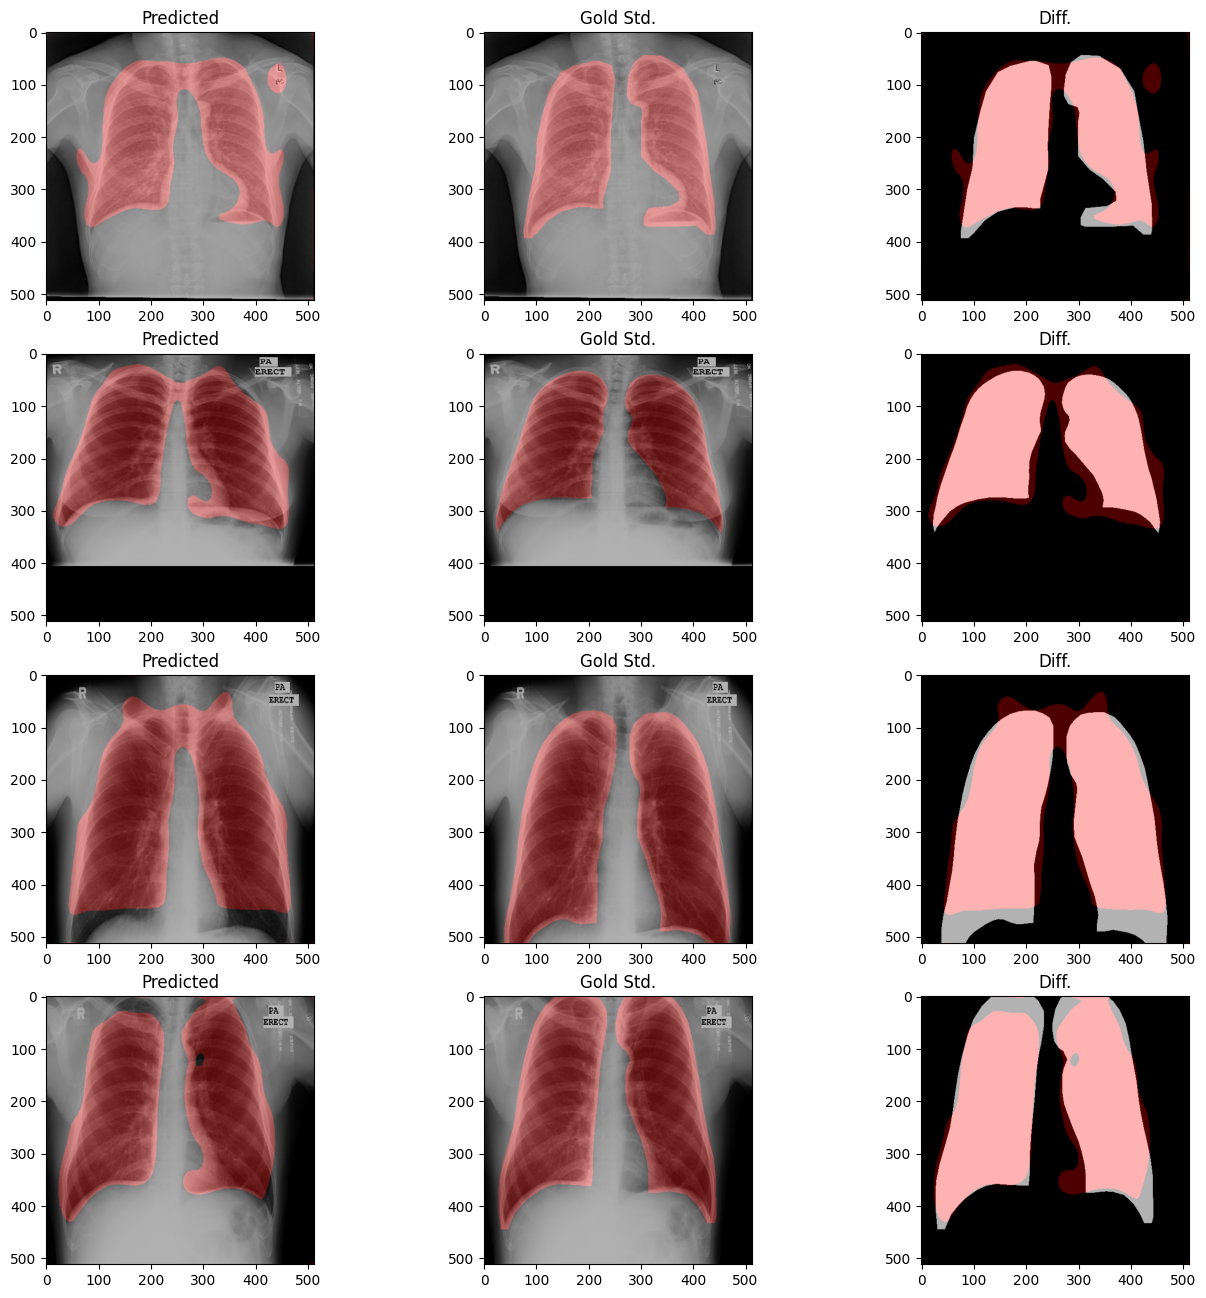

In [ ]:
image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/CHNCXR_0006_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/CHNCXR_0006_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/CHNCXR_0006_0_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0011_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0011_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0011_0_mask.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0022_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0022_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0022_0_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0030_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0030_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/input/segmentation /test/MCUCXR_0030_0_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))

